In [30]:
## ----------------------------------------------------------------- ##
##  File   : Smoothing Filter.ipynb
##  Author : peach
##  Date   : 21 Dec 2017
## ----------------------------------------------------------------- ##
#
# Used to help develop an algorithm for properly smoothing and normalizing RGB outputs.

In [31]:
# Get into here with
# $ ipython3 notebook
#
# Then choose "Smoothing Filter".

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def first_derivative(x):
    n_elements = x.size
    result = np.zeros(x.shape)
    
    for i in range(n_elements-1):
        result[i+1] = x[i+1] - x[i]
        
    return result

In [33]:
def fast_log(x):
    result = x*0
    a=0
    b=0
    c=0
    
    if (x < 2):
        return result
    elif (x < 10):
        a = -6.11e-3
        b = 0.152
        c = 0.301
    elif (x < 100):
        a = -1.03e-4
        b = 0.0208
        c = 0.916
    else:
        a = -1.06e-6
        b = 2.11e-3
        c = 1.91

    result = a * x * x + b * x + c;
    return result;

In [34]:
# Maximum Calculation Function
def get_max (x):
    ts_maximum = 0.999
    n_values = x.size
    y = np.zeros(n_values)
    yi = 0
    for i in range(n_values):
        yi = x[i] if x[i] > yi else yi * ts_maximum
        y[i] = yi
        
    return y

In [35]:
# Maximum Calculation Function
def get_min (x):
    ts_minimum = 0.999
    n_values = x.size
    y = np.zeros(n_values)
    yi = 0
    for i in range(n_values):
        yi = x[i] if x[i] < yi else yi * ts_minimum
        y[i] = yi
        
    return y

In [36]:
# Smoothing function.
def smooth (x_input, time_constant):
    n_elements = x_input.size
    output = np.zeros(n_elements)
    x = 0
    
    for i in range(n_elements):
        x = x_input[i] * (1-time_constant) + x * time_constant
        output[i] = x
        
    return output

In [215]:
# Load data
filename='buckets_raw2.dat'
buckets = np.loadtxt(filename, delimiter=",")

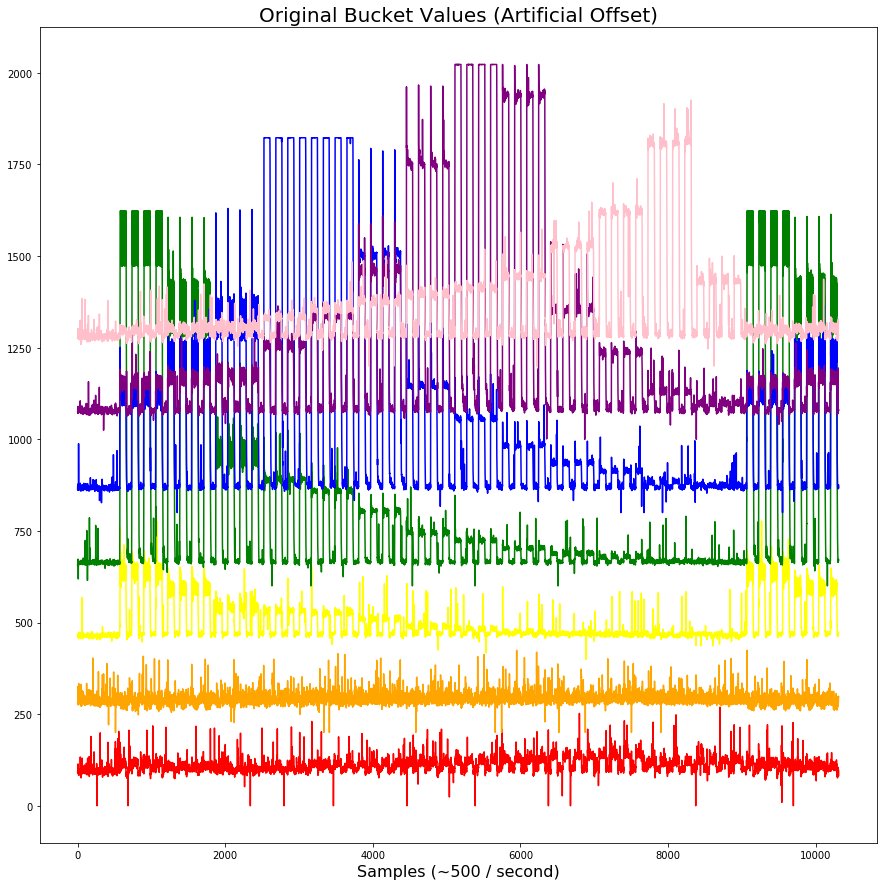

In [216]:
# Plot the input buckets
plt.figure(figsize=(15,15))
plt.plot(buckets[:,0],'red')
plt.plot(buckets[:,1]+200,'orange')
plt.plot(buckets[:,2]+400,'yellow')
plt.plot(buckets[:,3]+600,'green')
plt.plot(buckets[:,4]+800,'blue')
plt.plot(buckets[:,5]+1000,'purple')
plt.plot(buckets[:,6]+1200,'pink')
plt.title('Original Bucket Values (Artificial Offset)', fontsize=20)
plt.xlabel('Samples (~500 / second)', fontsize=16)

In [217]:
# Bin the bins into the various frequencies.
n_elements = np.shape(buckets)[0]

rgb_allocation = np.array([
    [1,1,1,0,0,0,0],
    [0,0,0,1,1,0,0],
    [0,0,0,0,0,1,1],
])

rgb_values = np.zeros([n_elements,3])

log_buckets = np.zeros(buckets.shape)
# Take the log in each element
for row in range(buckets.shape[0]):
    for col in range(buckets.shape[1]):
        log_buckets[row,col] = fast_log(buckets[row,col])

for i in range(n_elements):
    rgb_value = np.dot(rgb_allocation,log_buckets[i])
    rgb_values[i,:] = rgb_value

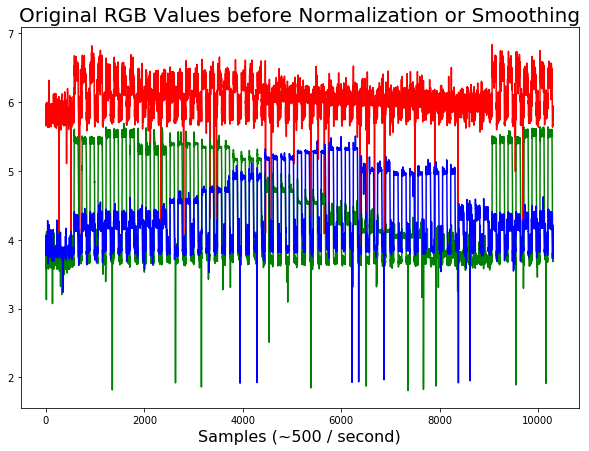

In [218]:
# Plot it for sanity.

plt.figure(figsize=(10,7))
plt.plot(rgb_values[:,0], color='r')
plt.plot(rgb_values[:,1], color='g')
plt.plot(rgb_values[:,2], color='b')
plt.title('Original RGB Values before Normalization or Smoothing', fontsize=20)
plt.xlabel('Samples (~500 / second)', fontsize=16)

In [219]:
# Average Red
np.average(rgb_values[:,0])

6.0287303421200651

In [220]:
# Average Green
np.average(rgb_values[:,1])

4.3006869757230151

In [221]:
# Average Blue
np.average(rgb_values[:,2])

4.3137119418232954

In [222]:
# Nominal Averages
# What we assume to be the "zero-input" level. These are measured from the above averages
# When no input signal is delivered.

nominal_averages = [6,3.9,3.75]

In [232]:
# Let's focus on the Red for now.
color = 0
x_raw = rgb_values[:,color]
nominal_average = nominal_averages[color]

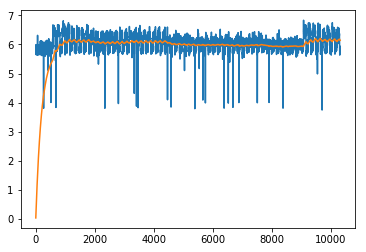

In [233]:
# Define the nominal average.
#x_average = np.ones(x_raw.shape)*nominal_average

# Calculate a running average. (normally use a smoothing factor with long settling time)
x_average = smooth(x_raw, 0.995)

plt.plot(x_raw)
plt.plot(x_average)

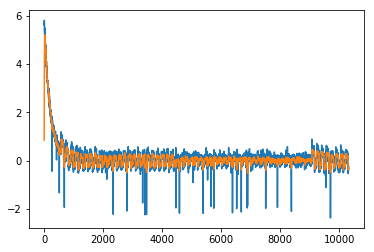

In [234]:
# Smooth Slightly
x_smooth1 = smooth(x_raw-x_average, 0.85)
plt.plot(x_raw-x_average)
plt.plot(x_smooth1)

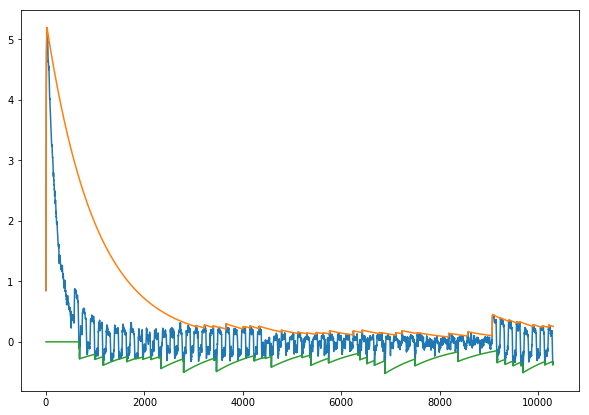

In [235]:
# Get the max and min profile from the average.
xMax = get_max(x_smooth1)
xMin = get_min(x_smooth1)

plt.figure(figsize=(10,7))
plt.plot(x_smooth1)
plt.plot(xMax)
plt.plot(xMin)

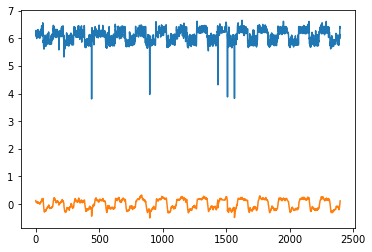

In [236]:
# And have a close-up view of the smoothing effect.
plt.plot(x_raw[1900:4300])
plt.plot(x_smooth1[1900:4300])

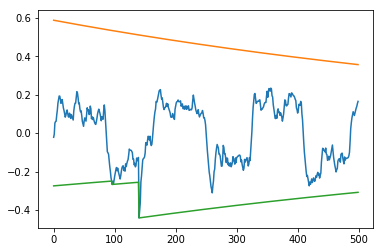

In [237]:
x_max = get_max(x_smooth1)
x_min = get_min(x_smooth1)

plt.plot(x_smooth1[2200:2700])
plt.plot(x_max[2200:2700])
plt.plot(x_min[2200:2700])

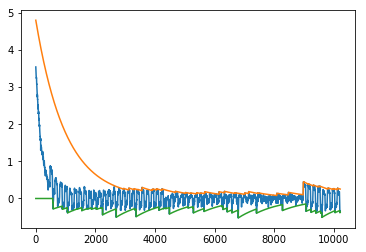

In [238]:
plt.plot(x_smooth1[100::])
plt.plot(x_max[100::])
plt.plot(x_min[100::])

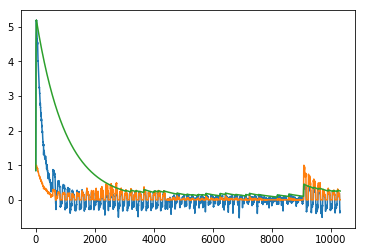

In [239]:
# Normalize for 0 to 255. Note that anything below zero currently is filter noise.

x_normalized = np.zeros(x_smooth1.shape)
x_envelope = np.zeros(x_max.shape)

cutoff_a = 0.45
cutoff_b = 0.1

slope = (1/cutoff_a)/(cutoff_a- cutoff_b)
b = -slope * cutoff_b

for i in range(x_smooth1.size):
    # Only keep positive values of the signal.
    x_normalized[i] = x_smooth1[i] if x_smooth1[i] > 0  else 0
    
    # The envelope is generally equal to 1/xMax but if xMax is too small, we reduce
    # its contribution or zero it out altogether.
    if (x_max[i] < cutoff_b):
        # Zero out result.
        x_envelope[i] = 0
    elif (x_max[i] < cutoff_a):
        # x_max is on thin ice, so we reduce its amplitude.
        x_envelope[i] = slope * x_max[i] + b
    else:
        x_envelope[i] = 1 / x_max[i]

x_normalized = x_normalized * x_envelope

plt.plot(x_smooth1)
plt.plot(x_normalized)
plt.plot(x_max)